In [20]:
import pandas as pd
import numpy as np

from scipy.spatial.distance import cdist
from scipy.stats import spearmanr
from sklearn.metrics import r2_score

import scanpy as sc
import anndata as an
import scvi
from scipy.stats import zscore

import matplotlib.pyplot as plt
import seaborn as sns
from pycirclize import Circos

In [2]:
%%time

fpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/pipeline_outputs/integrated_anndata/cell_cycle/pseudotime.h5ad"
adata = sc.read_h5ad(fpath)
adata

CPU times: user 277 ms, sys: 3.71 s, total: 3.98 s
Wall time: 5.75 s


AnnData object with n_obs × n_vars = 6895 × 15906
    obs: 'batch', 'phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'n_reads', 'raw_clusters', 'bbknn_clusters', 'harmony_clusters', 'cluster_str', 'barcoded_phase', 'S_score', 'G2M_score', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices', 'G1_pseudotime', 'G1_order', 'G2M_pseudotime', 'G2M_order', 'mean_pseudotime', 'mean_order', 'nnz', 'velocyto_cell_id', 'cell_id', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'leiden', 'cluster_phase', 'early_g1_score', 'G1_stage', 'global_ordering', 'global_ordering_bin', 'velocity_self_tra

# Plot by Order

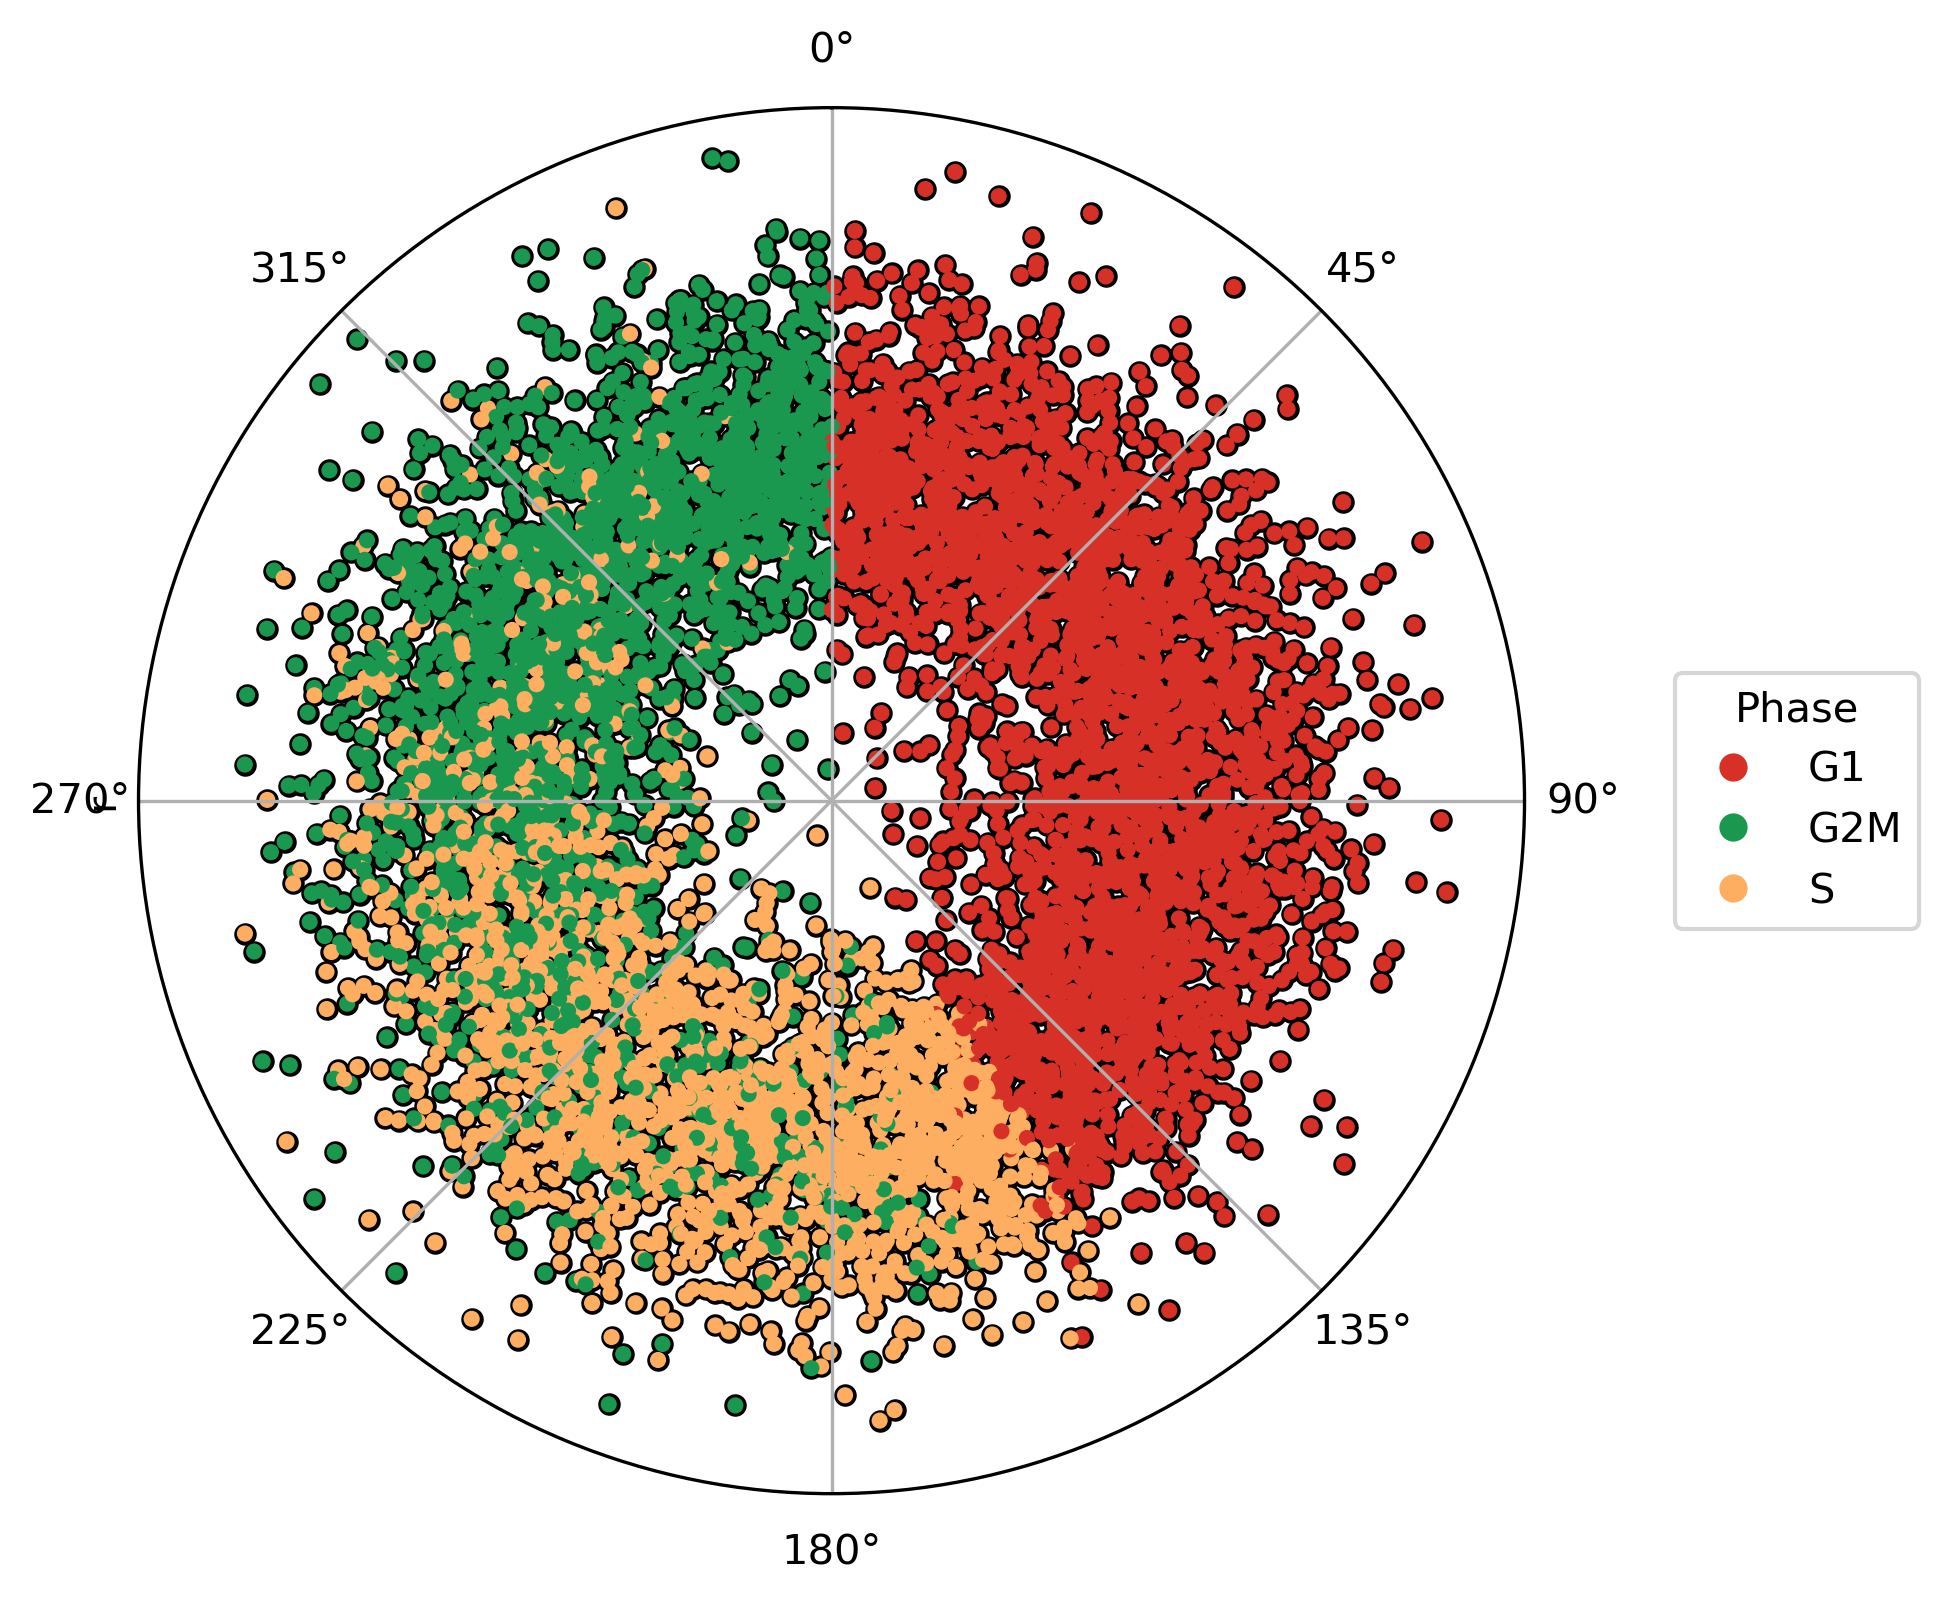

In [3]:
order_column = 'global_ordering'

pdf = adata.obs.copy()

# Pull the ordering
s = pdf[order_column].astype(float)

# Map to angle [0, 2π)
theta = 2 * np.pi * (s - s.min()) / (s.max() - s.min() + 1e-12)

# radius
r = np.random.normal(1, 0.01, size=theta.shape)

# Add to obs for convenience
pdf['theta'] = theta
pdf['r'] = r

# Polar plot
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 6
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

palette = {
    "G1": "#D73027",        
    "S": "#FDAE61",       
    "G2M": "#1A9850",    
    "unknown": "#B0B0B0", 
}



sns.scatterplot(
    data=pdf,
    x='theta',
    y='r',
    c='k',
    ec='k',
    s=25,
    ax=ax,
)

sns.scatterplot(
    data=pdf,
    x='theta',
    y='r',
    hue='cluster_phase',
    palette=palette,
    ec='none',
    s=15,
    ax=ax,
)

ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_rticks([])
ax.set_xlabel("")

sns.move_legend(
    ax, 
    loc='center right',
    title='Phase',
    markerscale=1.75,
    bbox_to_anchor=(1.3, 0.5),
)

plt.show()

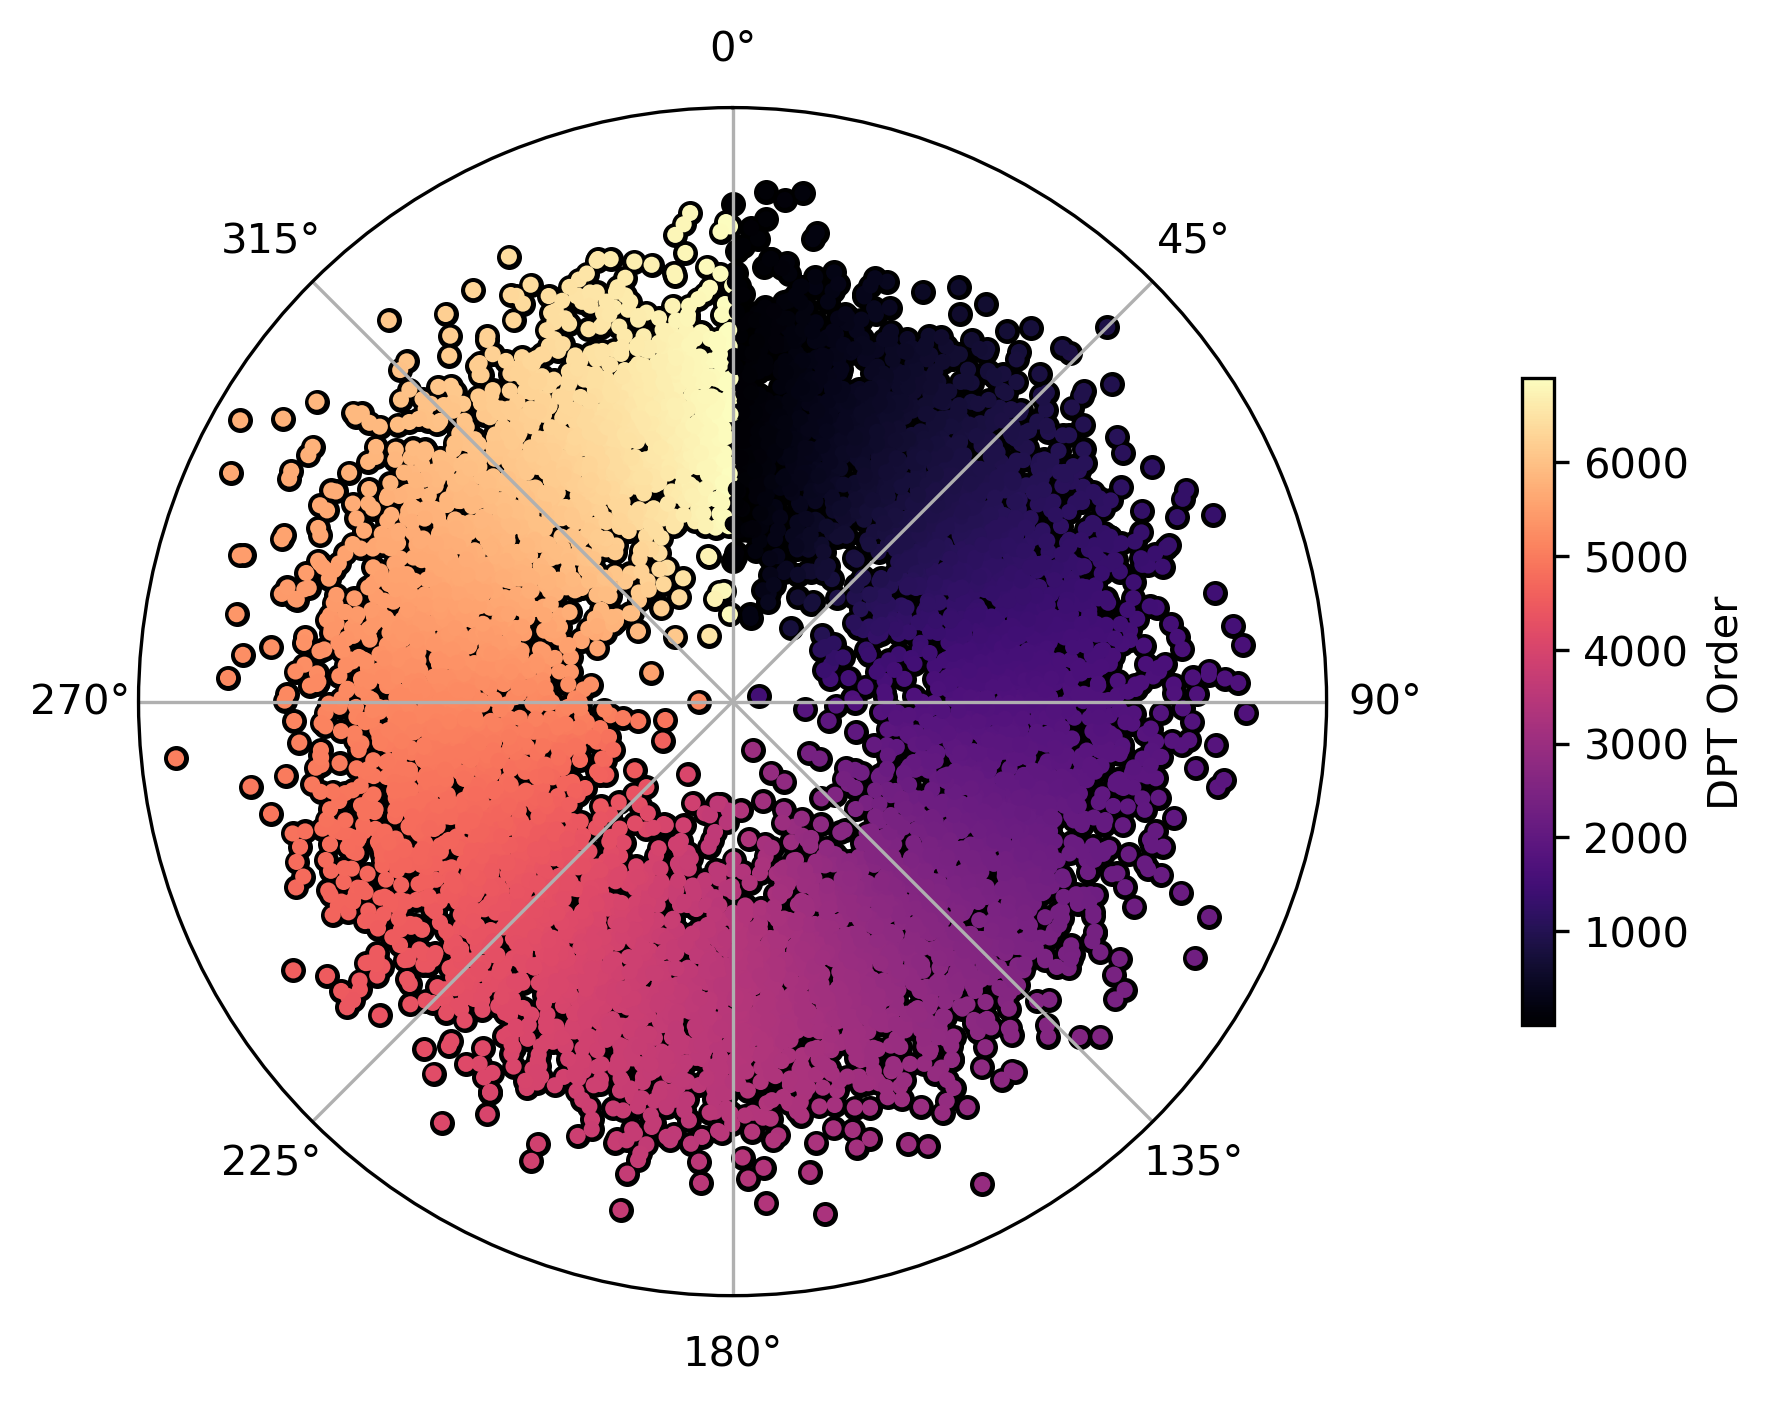

In [4]:
order_column = 'global_ordering'

pdf = adata.obs.copy()
s = pdf[order_column].astype(float)

# map to polar
theta = 2 * np.pi * (s - s.min()) / (s.max() - s.min() + 1e-12)
r = np.random.normal(1, 0.01, size=theta.shape)

# Add to df for convenience
pdf['theta'] = theta
pdf['r'] = r

# Polar plot
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 7, 7
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# Background (black points)
ax.scatter(
    pdf['theta'],
    pdf['r'],
    c='k',
    s=25,
    edgecolors='k',
)

# Colored points by pseudotime (store the handle!)
sc = ax.scatter(
    pdf['theta'],
    pdf['r'],
    c=pdf['global_ordering'],
    cmap='magma',
    s=15,
    edgecolors='none'
)

ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_rticks([])
ax.set_xlabel("")

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, shrink=0.4, pad=0.12)
cbar.set_label("DPT Order")

plt.show()

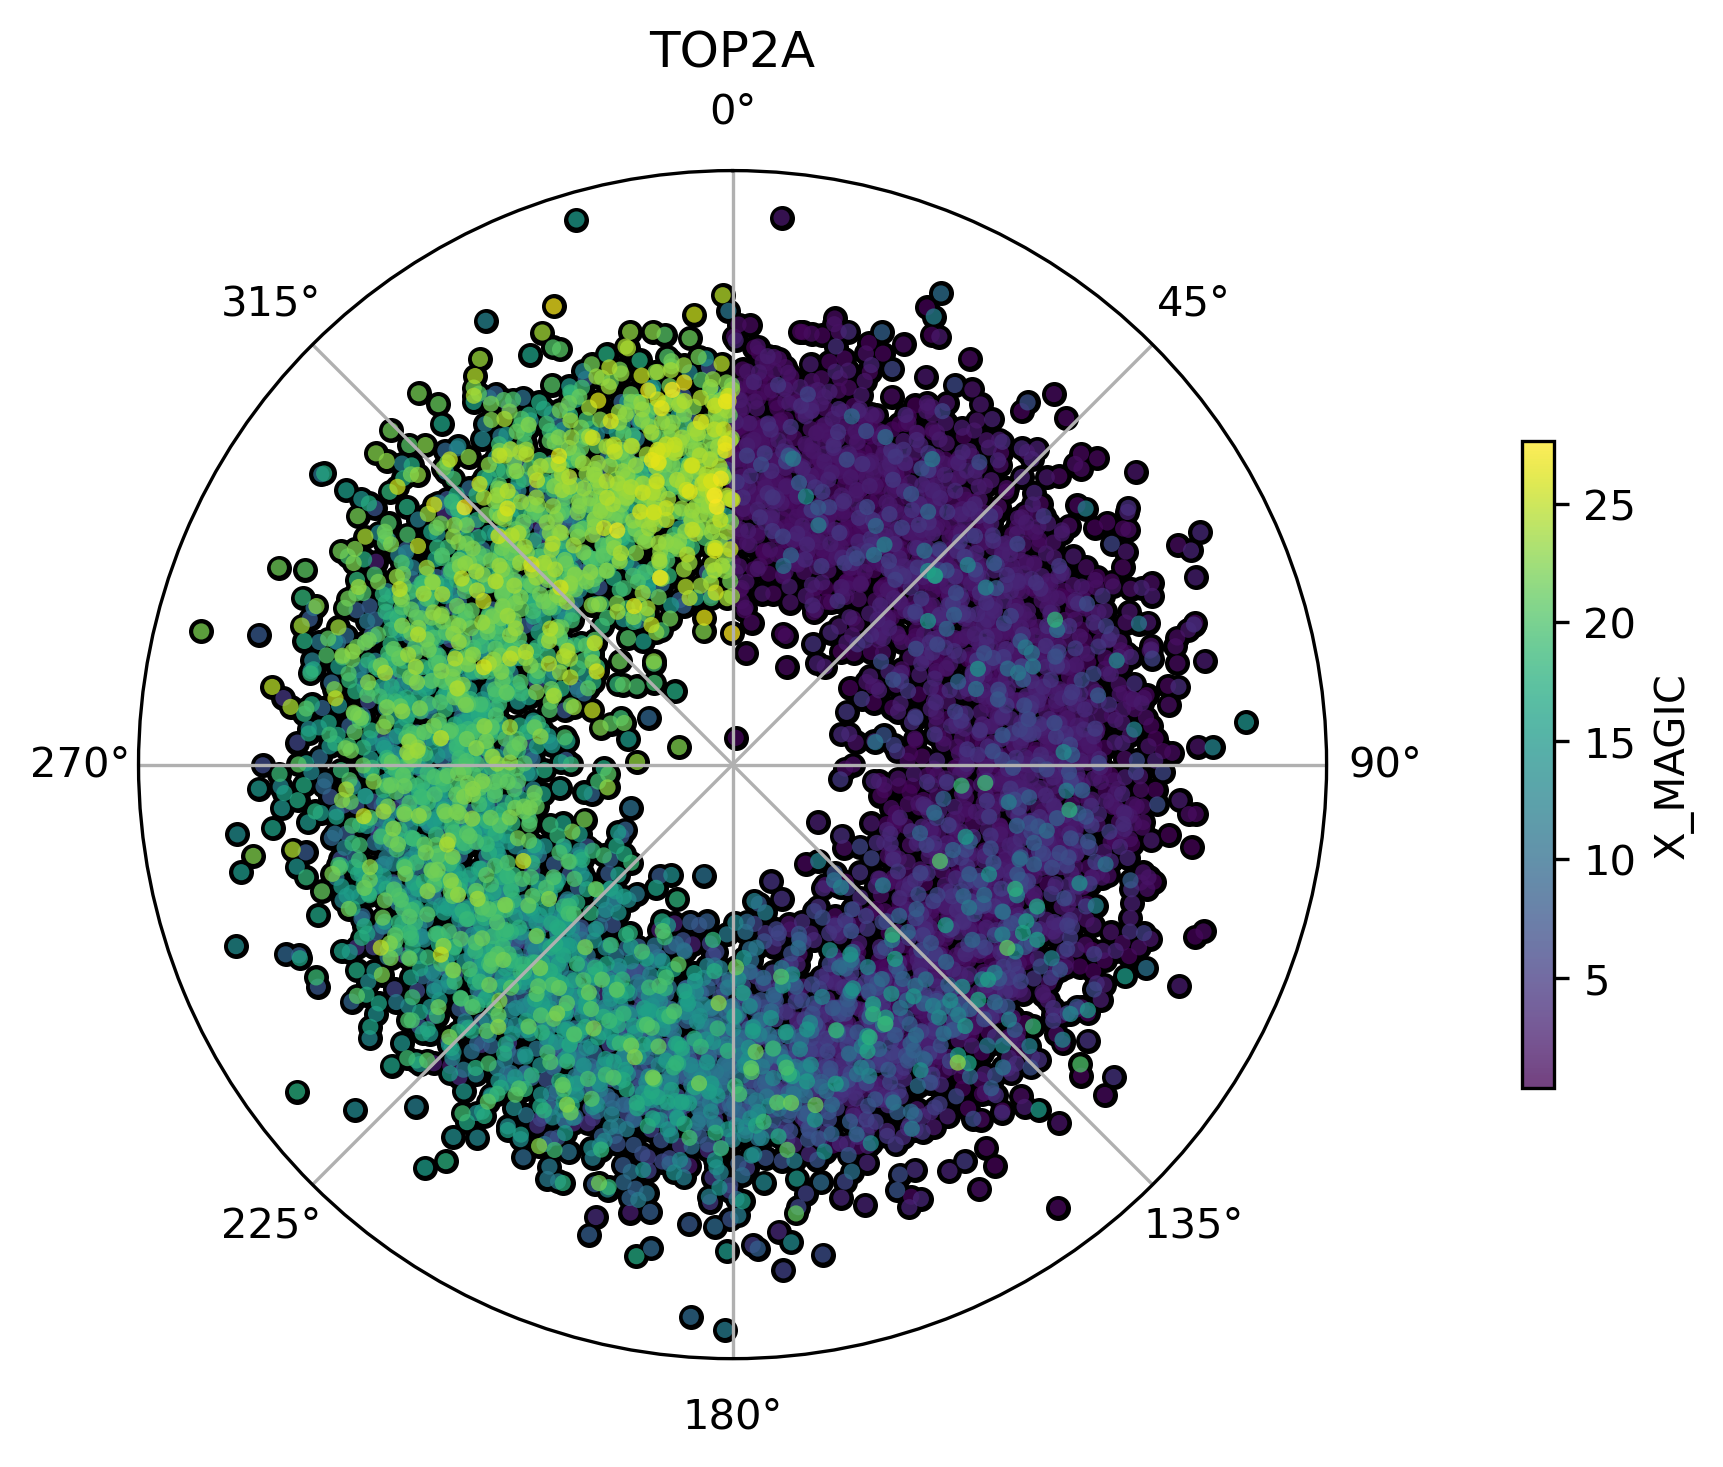

In [5]:
# gene = 'CCNE2'
# gene = 'CCND2'
gene = 'TOP2A'
# layer = 'scvi'
layer = 'X_magic'
order_column = 'global_ordering'


pdf = adata.obs.copy()
s = pdf[order_column].astype(float)

# map to polar
theta = 2 * np.pi * (s - s.min()) / (s.max() - s.min() + 1e-12)
r = np.random.normal(1, 0.01, size=theta.shape)

# Add to df for convenience
pdf['theta'] = theta
pdf['r'] = r
pdf['gene'] = adata[:, gene].to_df(layer=layer)[gene].values
pdf = pdf.sort_values(by='gene') # sort by expression

# Polar plot
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 7, 7
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# Background (black points)
ax.scatter(
    pdf['theta'],
    pdf['r'],
    c='k',
    s=25,
    edgecolors='k',
)

# Colored points by pseudotime (store the handle!)
sc = ax.scatter(
    pdf['theta'],
    pdf['r'],
    c=pdf['gene'],
    cmap='viridis',
    s=15,
    alpha=0.75,
    edgecolors='none'
)

ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_rticks([])
ax.set_xlabel("")

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, shrink=0.4, pad=0.12)
cbar.set_label(f"{layer.upper()}")
plt.title(gene)

plt.show()

# Convert to Time

In [6]:
print(adata.obs['cluster_phase'].value_counts().to_string())

cluster_phase
G1     2882
G2M    2123
S      1890


In [7]:
print(adata.obs[['cluster_phase', 'global_ordering']].head().to_string())

                   cluster_phase  global_ordering
AAACCAAAGGGTAGCA-1             S           4893.0
AAACCAAAGTAAGGGT-1            G1            881.0
AAACCATTCAGGTAGG-1           G2M           6694.0
AAACCATTCCAGCCCT-1            G1           2530.0
AAACCATTCGTGACCG-1            G1            344.0


In [8]:
# target durations (hours)
dur_h = {'G1': 12.0, 'S': 6.0, 'G2M': 4.0}
order = ['G1', 'S', 'G2M']
T = sum(dur_h.values())  # 22.0 total

# fractions of total
frac = {k: dur_h[k] / T for k in order}

# cumulative offsets in [0,1)
offset_frac = pd.Series(
    [0.0] + list(np.cumsum([frac[p] for p in order[:-1]])),
    index=order
).to_dict()

# within-phase percentile u ∈ [0,1]
u = (
    adata.obs.groupby('cluster_phase')['global_ordering']
        .transform(lambda x: (x.rank(method='first') - 1) / max(len(x) - 1, 1))
)

# map to global fraction and hours
phase_off = adata.obs['cluster_phase'].map(offset_frac).astype(float)
phase_frac = adata.obs['cluster_phase'].map(frac).astype(float)
global_frac = phase_off + u * phase_frac
cycle_time_h = global_frac * T  # [0,22)

# build separate dataframe
time_df = pd.DataFrame({
    "cluster_phase": adata.obs['cluster_phase'].values,
    "global_ordering": adata.obs['global_ordering'].values,
    "within_phase_rank": u.values,
    "phase_offset_frac": phase_off.values,
    "phase_frac": phase_frac.values,
    "cycle_time_h": cycle_time_h.values
}, index=adata.obs.index)

print(time_df.head().to_string())

                   cluster_phase  global_ordering  within_phase_rank  phase_offset_frac  phase_frac  cycle_time_h
AAACCAAAGGGTAGCA-1             S           4893.0           0.820540           0.545455    0.272727     16.923240
AAACCAAAGTAAGGGT-1            G1            881.0           0.305449           0.000000    0.545455      3.665394
AAACCATTCAGGTAGG-1           G2M           6694.0           0.905749           0.818182    0.181818     21.622997
AAACCATTCCAGCCCT-1            G1           2530.0           0.877820           0.000000    0.545455     10.533842
AAACCATTCGTGACCG-1            G1            344.0           0.119056           0.000000    0.545455      1.428671


/tmp/ipykernel_3951123/353361790.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('cluster_phase')['global_ordering']


/tmp/ipykernel_3951123/1861045753.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


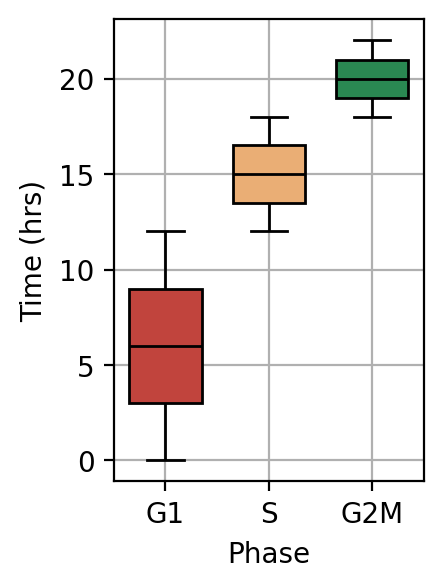

In [9]:
palette = {
    "G1": "#D73027",        
    "S": "#FDAE61",       
    "G2M": "#1A9850",    
    "unknown": "#B0B0B0", 
}

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 2, 3

sns.boxplot(
    data=time_df,
    x='cluster_phase',
    y='cycle_time_h',
    # hue='cluster_phase',
    order=order,
    palette=palette,
    legend=False,
    linecolor='k',
    width=0.7,
)

plt.ylabel("Time (hrs)")
plt.xlabel("Phase")
plt.grid(True)

In [10]:
adata.obs['cycle_time_h'] = time_df['cycle_time_h']

# Time Clock Plot

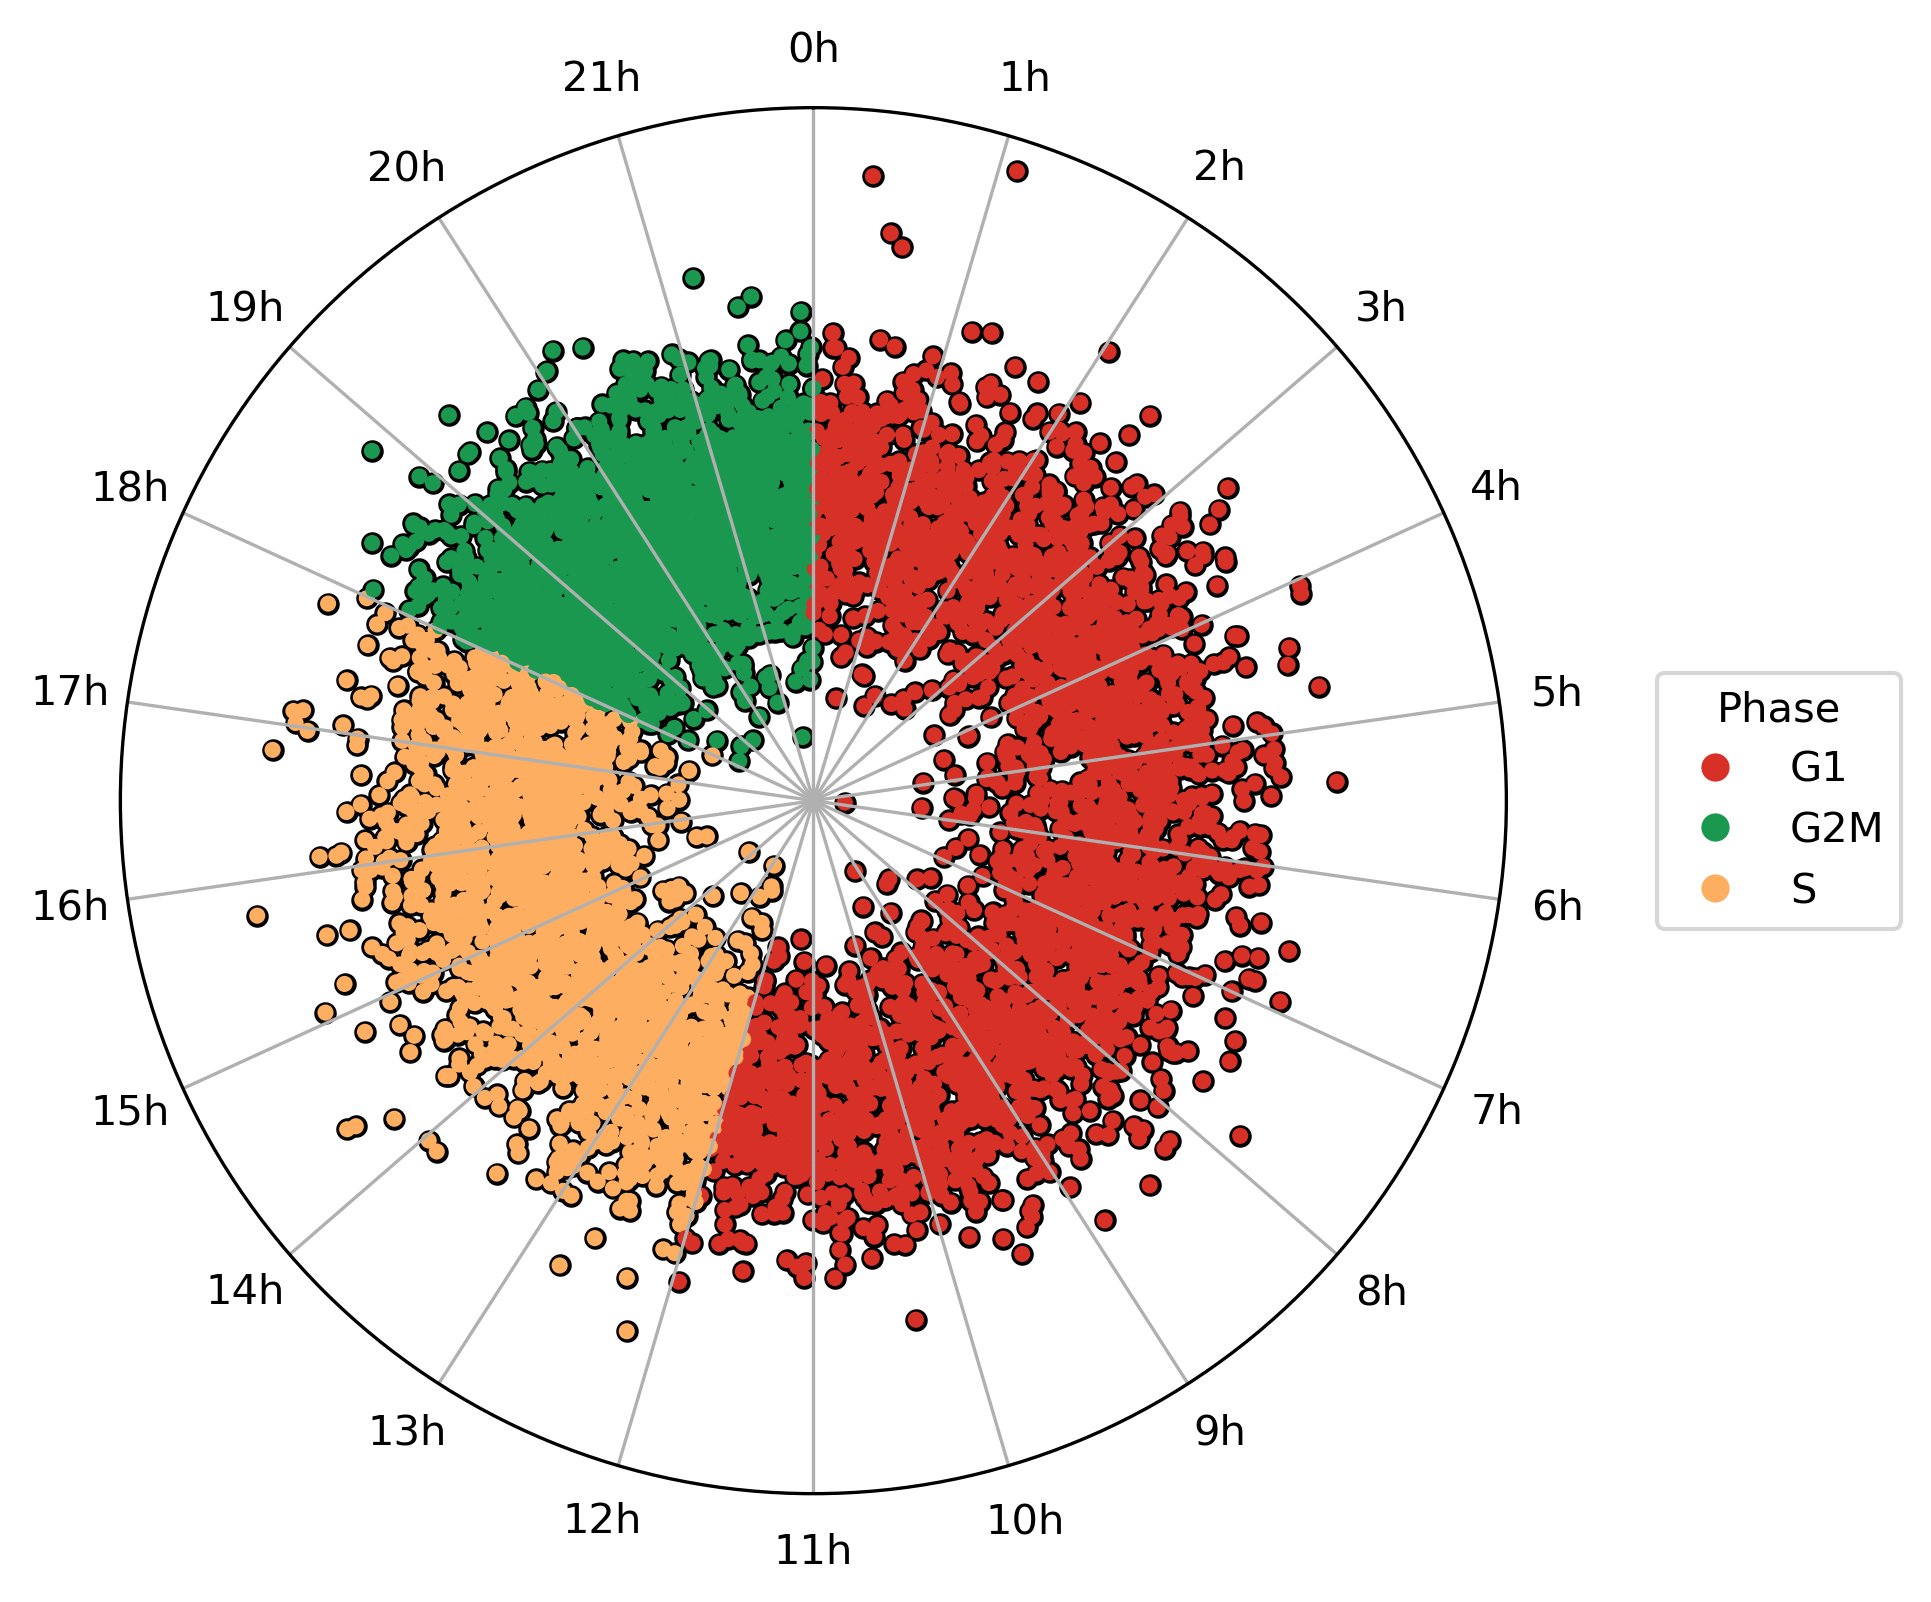

In [19]:
order_column = 'cycle_time_h'

pdf = adata.obs.copy()
s = pdf[order_column].astype(float)

# map to polar
theta = 2 * np.pi * (s - s.min()) / (s.max() - s.min() + 1e-12)
r = np.random.normal(1, 0.01, size=theta.shape)

# Add to df for convenience
pdf['theta'] = theta
pdf['r'] = r

# Polar plot
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 6
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})


sns.scatterplot(
    data=pdf,
    x='theta',
    y='r',
    c='k',
    ec='k',
    s=25,
    ax=ax,
)

sns.scatterplot(
    data=pdf,
    x='theta',
    y='r',
    hue='cluster_phase',
    palette=palette,
    ec='none',
    s=15,
    ax=ax,
)

ax.set_theta_zero_location("N")
# --- Add 22 evenly spaced grid lines (1 per hour) ---
ax.set_theta_direction(-1)
ax.set_rticks([])
ax.set_xlabel("")
ax.set_ylabel("")

# --- Add 22 evenly spaced grid lines and hour labels ---
hours = np.arange(22)  # 0–21
angles = np.linspace(0, 2*np.pi, 22, endpoint=False)

ax.set_xticks(angles)
ax.set_xticklabels([f"{h}h" for h in hours])

sns.move_legend(
    ax, 
    loc='center right',
    title='Phase',
    markerscale=1.75,
    bbox_to_anchor=(1.3, 0.5),
)

plt.show()

# Circalize

In [39]:
# # Initialize circos sectors
# layer= 'scvi'
# sectors = {
#     "G1" : 12, 
#     "S" : 6, 
#     "G2M" : 4, 
# }

# genes = {
#     'G1' : ['CCND2'],
#     'S' : ['CCNE2'],
#     'G2M' : ['TOP2A'],
# }
# circos = Circos(sectors, space=5)

# for sector in circos.sectors:

#     phase = adata[adata.obs['cluster_phase'] == sector.name, :].copy()
#     gdf = phase[:, genes[sector.name]].to_df(layer=layer)

#     sector.text(f"{sector.name}", r=110, size=15)

#     for gene in gdf.columns:
#         track = sector.add_track((75, 100), r_pad_ratio=0.1)
#         track.axis()
#         track.xticks_by_interval(1)
#         track.scatter(
#             phase.obs['cycle_time_h'].values, 
#             gdf[gene].values,
#         )
#     break

# fig = circos.plotfig()

ValueError: x=np.float64(16.923239809422974) is invalid range of 'S' sector.
# Sector = 'S'
# Size = 6 (0 - 6)
# Degree Size = 94.09 (193.18 - 287.27)
# Track List = ['Track01']


In [12]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)